In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output


Detected environment: local


In [2]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
#kgs.enable_module_profiling(kgs)
import pack_ga3
import pack_runner
fastMode = False
kgs.debugging_mode = 1

runner = pack_ga3.baseline()
len(runner.ga.ga_base.move.moves)
runner.ga.ga_base.move.moves[6][0].force_center=True

<Axes: >

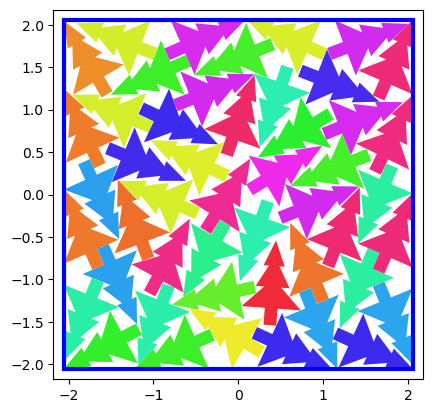

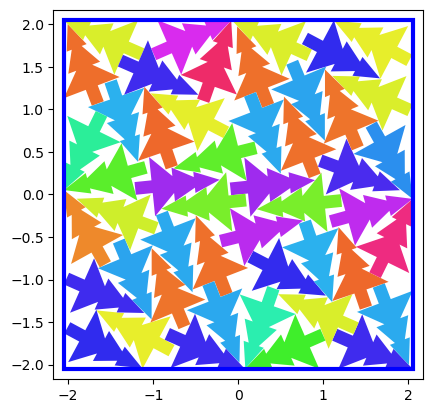

In [3]:
import pack_vis_sol
pop = pack_ga3.Population()
pop.genotype = kgs.SolutionCollectionSquare().create_empty(2,48)
pop.phenotype = kgs.SolutionCollectionSquare().create_empty(2,48)
pop.set_dummy_fitness()
pop.genotype.xyt[0,...] = kgs.dill_load(kgs.temp_dir + '/controller_runs/done/ga_N48_seed86_done.pickle').ga.champions[0].phenotype.xyt[0,...]
pop.genotype.h[0,...] = kgs.dill_load(kgs.temp_dir + '/controller_runs/done/ga_N48_seed86_done.pickle').ga.champions[0].phenotype.h[0,...]
pop.genotype.xyt[1,...] = kgs.dill_load(kgs.temp_dir + '/controller_runs/done/ga_N48_seed87_done.pickle').ga.champions[0].phenotype.xyt[0,...]
pop.genotype.h[1,...] = kgs.dill_load(kgs.temp_dir + '/controller_runs/done/ga_N48_seed87_done.pickle').ga.champions[0].phenotype.h[0,...]
pop.phenotype = copy.deepcopy(pop.genotype)
pack_vis_sol.pack_vis_sol(pop.phenotype, margin_factor=0.03, solution_idx=0)
pack_vis_sol.pack_vis_sol(pop.phenotype, margin_factor=0.03, solution_idx=1)
# pop.merge(copy.deepcopy(runner.ga.ga_list[1].champions[0]))
# for i in range(100):
#     pop.merge(copy.deepcopy(runner.ga.ga_list[0].champions[0]))

Moves to visualize: ['MoveRandomTree', 'JiggleTreeSmall', 'JiggleTreeBig', 'JiggleClusterSmall', 'JiggleClusterBig', 'Translate', 'Twist']


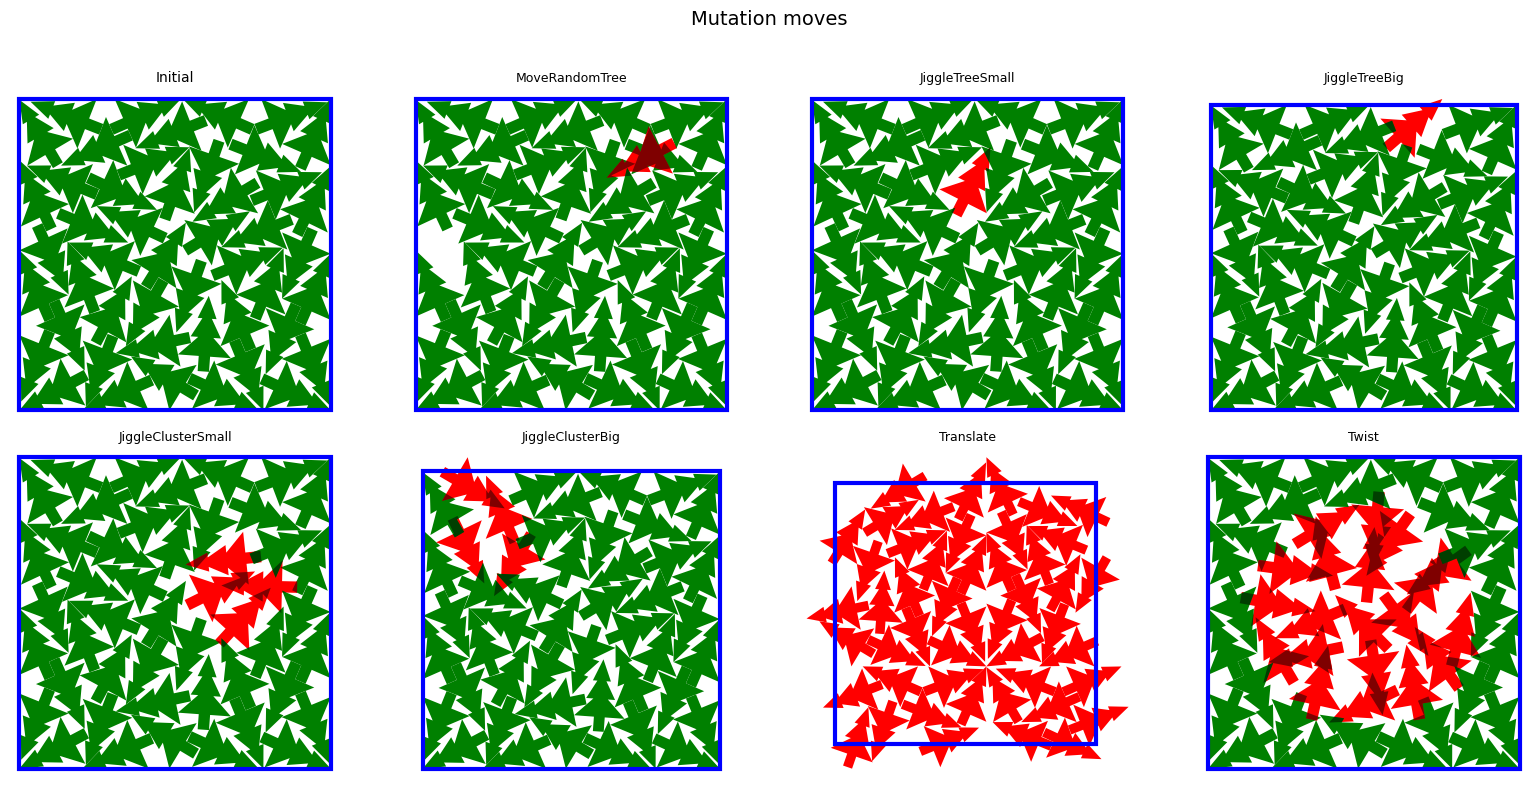

In [4]:
# Visualization of the first 7 mutation moves (non-crossover)
# Configurable seeds for each move to find visually attractive examples
import pack_ga3
import pack_move
import pack_vis_sol
importlib.reload(pack_vis_sol)
importlib.reload(pack_move)

# Seeds for each move - adjust these to find attractive examples
SEEDS = [42, 123, 456, 789, 1011, 1213, 1418]

# Get the first 7 moves (excluding the last 2 crossover moves)
all_moves = runner.ga.ga_base.move.moves[:7]
move_names = [m[1] for m in all_moves]
print("Moves to visualize:", move_names)

# Create figure with 2 rows x 4 columns grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()  # Flatten for easy indexing

# Plot initial solution (all green) in the first position
N_trees = pop.genotype.xyt.shape[1]
initial_colors = ['green'] * N_trees
pack_vis_sol.pack_vis_sol(pop.genotype.convert_to_phenotype(), ax=axes[0], 
                          solution_idx=0, margin_factor=0.03, facecolors=initial_colors)
axes[0].set_title("Initial", fontsize=10)
axes[0].set_aspect('equal')
axes[0].axis('off')

# Apply each move and plot results
for i, (move_item, seed) in enumerate(zip(all_moves, SEEDS)):
    move = copy.deepcopy(move_item[0])
    move_name = move_item[1]
    
    # Create generator with configurable seed
    generator = cp.random.default_rng(seed=seed)
    
    # Deep copy and apply move
    pop_moved = copy.deepcopy(pop)
    move.do_move_vec(pop_moved, cp.array([0]), pop_moved.genotype, cp.array([1]), generator)
    pop_moved.genotype.canonicalize()
    
    # Detect changed trees by comparing xyt values element-wise
    original_xyt = pop.genotype.xyt[0].get()  # Shape: (N_trees, 3)
    moved_xyt = pop_moved.genotype.xyt[0].get()  # Shape: (N_trees, 3)
    
    # Trees are considered changed if any of x, y, or theta differ significantly
    diff = np.abs(original_xyt - moved_xyt)
    changed_trees = np.any(diff > 1e-6, axis=1)  # True if any of x,y,theta changed
    
    # Create facecolors: green for unchanged, red for changed
    facecolors = ['red' if changed else 'green' for changed in changed_trees]
    
    # Plot in position i+1 (position 0 is initial)
    ax = axes[i + 1]
    pack_vis_sol.pack_vis_sol(pop_moved.genotype.convert_to_phenotype(), ax=ax,
                              solution_idx=0, margin_factor=0.03, facecolors=facecolors)
    n_changed = np.sum(changed_trees)
    ax.set_title(f"{move_name}", fontsize=9)
    ax.set_aspect('equal')
    ax.axis('off')

plt.suptitle('Mutation moves', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room at top for suptitle
plt.savefig('moves_visualization.png', dpi=150, bbox_inches='tight')
plt.show()


In [6]:
move_crossover = copy.deepcopy(runner.ga.ga_base.move)
move_crossover.moves = move_crossover.moves[-2:]
for m in move_crossover.moves:
    m[0].enable_augmentation = False
move_crossover.moves[0][0].simple_mate_location = False

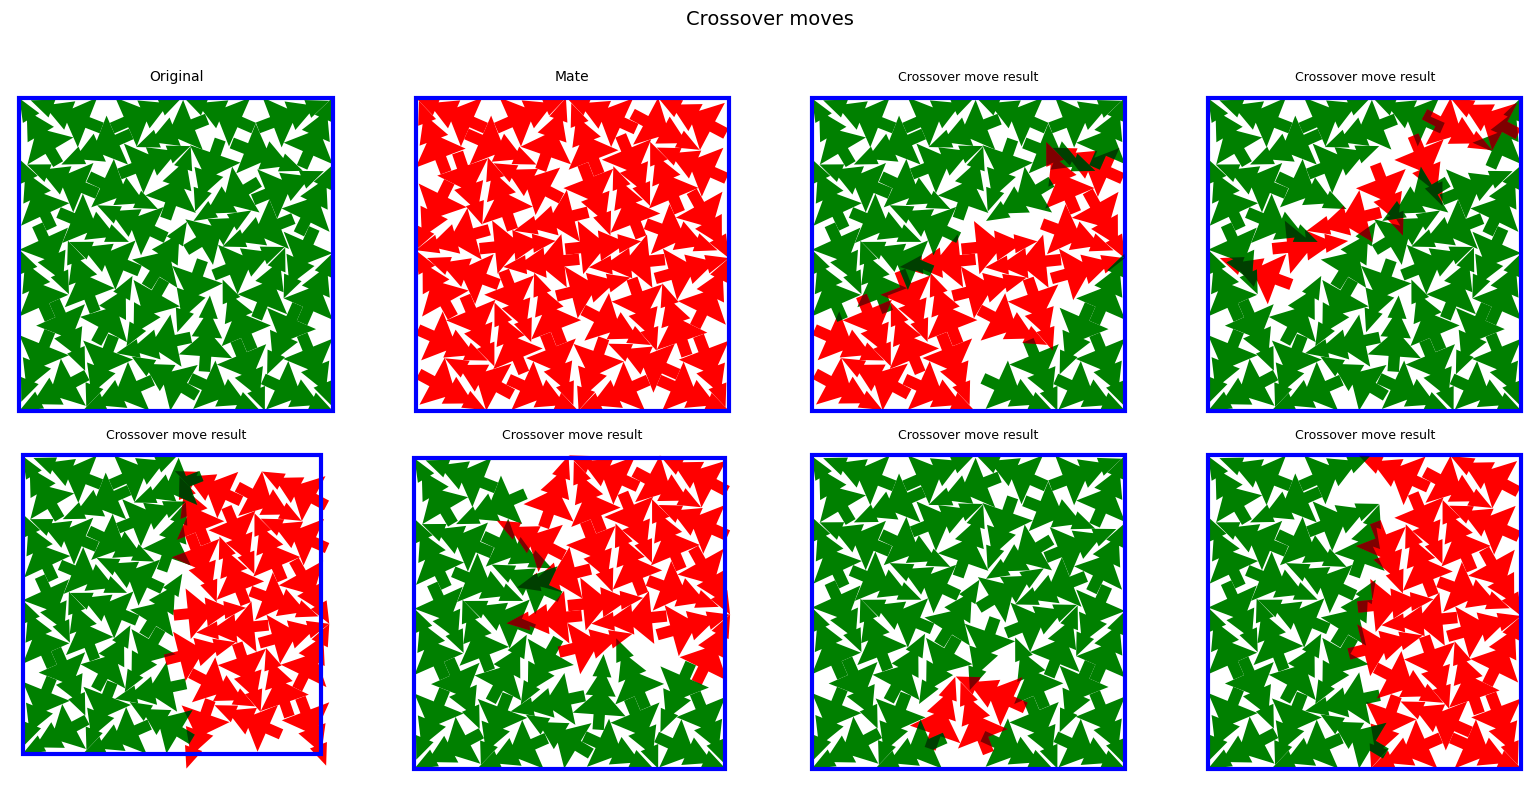

In [10]:
# Visualization of crossover moves
# Shows original (green) and mate (red) solutions, then 8 random crossover results

# Configurable seed for crossover visualizations
CROSSOVER_SEED = 42

# Create figure with 2 rows x 5 columns (2 initial + 8 results = 10)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

N_trees = pop.genotype.xyt.shape[1]

# Plot original solution (all green) 
original_colors = ['green'] * N_trees
pack_vis_sol.pack_vis_sol(pop.genotype.convert_to_phenotype(), ax=axes[0], 
                          solution_idx=0, margin_factor=0.03, facecolors=original_colors)
axes[0].set_title("Original", fontsize=10)
axes[0].set_aspect('equal')
axes[0].axis('off')

# Plot mate solution (all red)
mate_colors = ['red'] * N_trees
pack_vis_sol.pack_vis_sol(pop.genotype.convert_to_phenotype(), ax=axes[1], 
                          solution_idx=1, margin_factor=0.03, facecolors=mate_colors)
axes[1].set_title("Mate", fontsize=10)
axes[1].set_aspect('equal')
axes[1].axis('off')

# Generate 8 crossover results
generator = cp.random.default_rng(seed=CROSSOVER_SEED)

for i in range(6):
    # Deep copy and apply crossover move
    pop_crossed = copy.deepcopy(pop)
    move_crossover.do_move_vec(pop_crossed, cp.array([0]), pop_crossed.genotype, cp.array([1]), generator)
    pop_crossed.genotype.canonicalize()
    
    # Detect changed trees by comparing xyt values element-wise
    original_xyt = pop.genotype.xyt[0].get()  # Shape: (N_trees, 3)
    crossed_xyt = pop_crossed.genotype.xyt[0].get()  # Shape: (N_trees, 3)
    
    # Trees are considered changed if any of x, y, or theta differ significantly
    diff = np.abs(original_xyt - crossed_xyt)
    changed_trees = np.any(diff > 1e-6, axis=1)
    
    # Create facecolors: green for unchanged, red for changed
    facecolors = ['red' if changed else 'green' for changed in changed_trees]
    
    # Plot in position i+2 (positions 0 and 1 are initial solutions)
    ax = axes[i + 2]
    pack_vis_sol.pack_vis_sol(pop_crossed.genotype.convert_to_phenotype(), ax=ax,
                              solution_idx=0, margin_factor=0.03, facecolors=facecolors)
    n_changed = np.sum(changed_trees)
    ax.set_title(f"Crossover move result", fontsize=9)
    ax.set_aspect('equal')
    ax.axis('off')

plt.suptitle('Crossover moves', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('crossover_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
